In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ROOT_DIR = os.path.dirname(os.path.abspath(""))

file = os.path.join(ROOT_DIR, "data/sitges_access.csv")
df = pd.read_csv(file)
df.head()

,Unnamed: 0,server_name,IP,logname,authenticate,date,petition,URL,status,bytes,referer,user-agent,level
0,0,sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:00+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0
1,1,www.sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:01+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5223,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0
2,2,www.sitgesanytime.com,40.77.167.53,-,-,2024-01-22 00:00:06+01:00,GET,/ca/noticias/84/sitges-obt%C3%A9-el-certificat...,404,2509,-,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",5
3,3,sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:06+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0
4,4,www.sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:07+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5260,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0


In [2]:
df_clean = df.copy()

In [3]:
# shuffle the rows
df_clean = df_clean.sample(frac=1, random_state=42).reset_index(drop=True)
df_clean.head()

,Unnamed: 0,server_name,IP,logname,authenticate,date,petition,URL,status,bytes,referer,user-agent,level
0,111926,www.sitgesanytime.com,86.4.35.245,-,-,2024-01-23 19:14:34+01:00,GET,/plantilles/turisme/js/responsivemenu.js?v=3 H...,200,1913,https://www.sitgesanytime.com/en/pl409/blog/id...,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...,0
1,119842,www.sitgesanytime.com,168.119.65.47,-,-,2024-01-26 20:22:25+01:00,GET,/plantilles/turisme/css/estils-mw800.css?v=11 ...,200,3914,https://www.sitgesanytime.com/es/planifica-el-...,Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:...,0
2,56123,www.sitgesanytime.com,64.124.8.65,-,-,2024-01-23 10:59:54+01:00,GET,/ca/pl349/actualitat/noticies/id189/l-exposici...,200,13883,-,Mozilla/5.0 (compatible; ImagesiftBot; +images...,0
3,6249,www.sitgesanytime.com,216.244.66.199,-,-,2024-01-26 01:08:45+01:00,GET,/ca/noticias/20/la-gay-pride-reivindica-els-dr...,404,7269,-,Mozilla/5.0 (compatible; DotBot/1.2; +https://...,10
4,31977,www.sitgesanytime.com,168.119.65.45,-,-,2024-01-24 06:47:46+01:00,GET,/plantilles/turisme/css/estils-mw500.css?v=14 ...,200,1233,https://www.sitgesanytime.com/fr/pl50/planifie...,Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:...,0


### Drop useless columns

In [4]:
# remove columns
df_clean = df_clean.drop(columns=["logname", "authenticate", "Unnamed: 0", "server_name"])
df_clean.columns

Index(['IP', 'date', 'petition', 'URL', 'status', 'bytes', 'referer',
       'user-agent', 'level'],
      dtype='object')

### Group by IP and user-agent

In [5]:
df_temp = df_clean.copy()
groups = df_temp.groupby(["IP", "user-agent"])
df_temp["group"] = groups.ngroup()
counts = df_temp.value_counts("group")
df_clean["group"] = df_temp["group"]
counts

group
8436     23356
8435     18887
29842    10872
29844     9141
4858      5279
         ...  
11075        1
4712         1
11071        1
4722         1
34311        1
Name: count, Length: 34312, dtype: int64

### Compute time elapsed

In [6]:
df_temp = df_clean.copy()
df_temp["date"] = pd.to_datetime(df_temp["date"])
df_temp["date"].head()

0   2024-01-23 19:14:34+01:00
1   2024-01-26 20:22:25+01:00
2   2024-01-23 10:59:54+01:00
3   2024-01-26 01:08:45+01:00
4   2024-01-24 06:47:46+01:00
Name: date, dtype: datetime64[ns, UTC+01:00]

In [7]:
from tqdm import tqdm

# sort groups by date
df_temp = df_temp.sort_values("date")
for i, g in tqdm(enumerate(df_temp["group"].unique()), total=df_temp["group"].nunique()):
	group = df_temp.loc[df_temp["group"] == g].copy()
	group["elapsed"] = group["date"].diff().dt.total_seconds()
	group["elapsed"] = group["elapsed"].fillna(0)
	group["elapsed"] = np.log(group["elapsed"]+1)
	df_temp.loc[df_temp["group"] == g, "elapsed"] = group["elapsed"]

100%|██████████| 34312/34312 [02:46<00:00, 205.94it/s]


In [19]:
df_clean["elapsed"] = df_temp["elapsed"]
df_clean["order"] = df_temp.reset_index().index

### IP

223


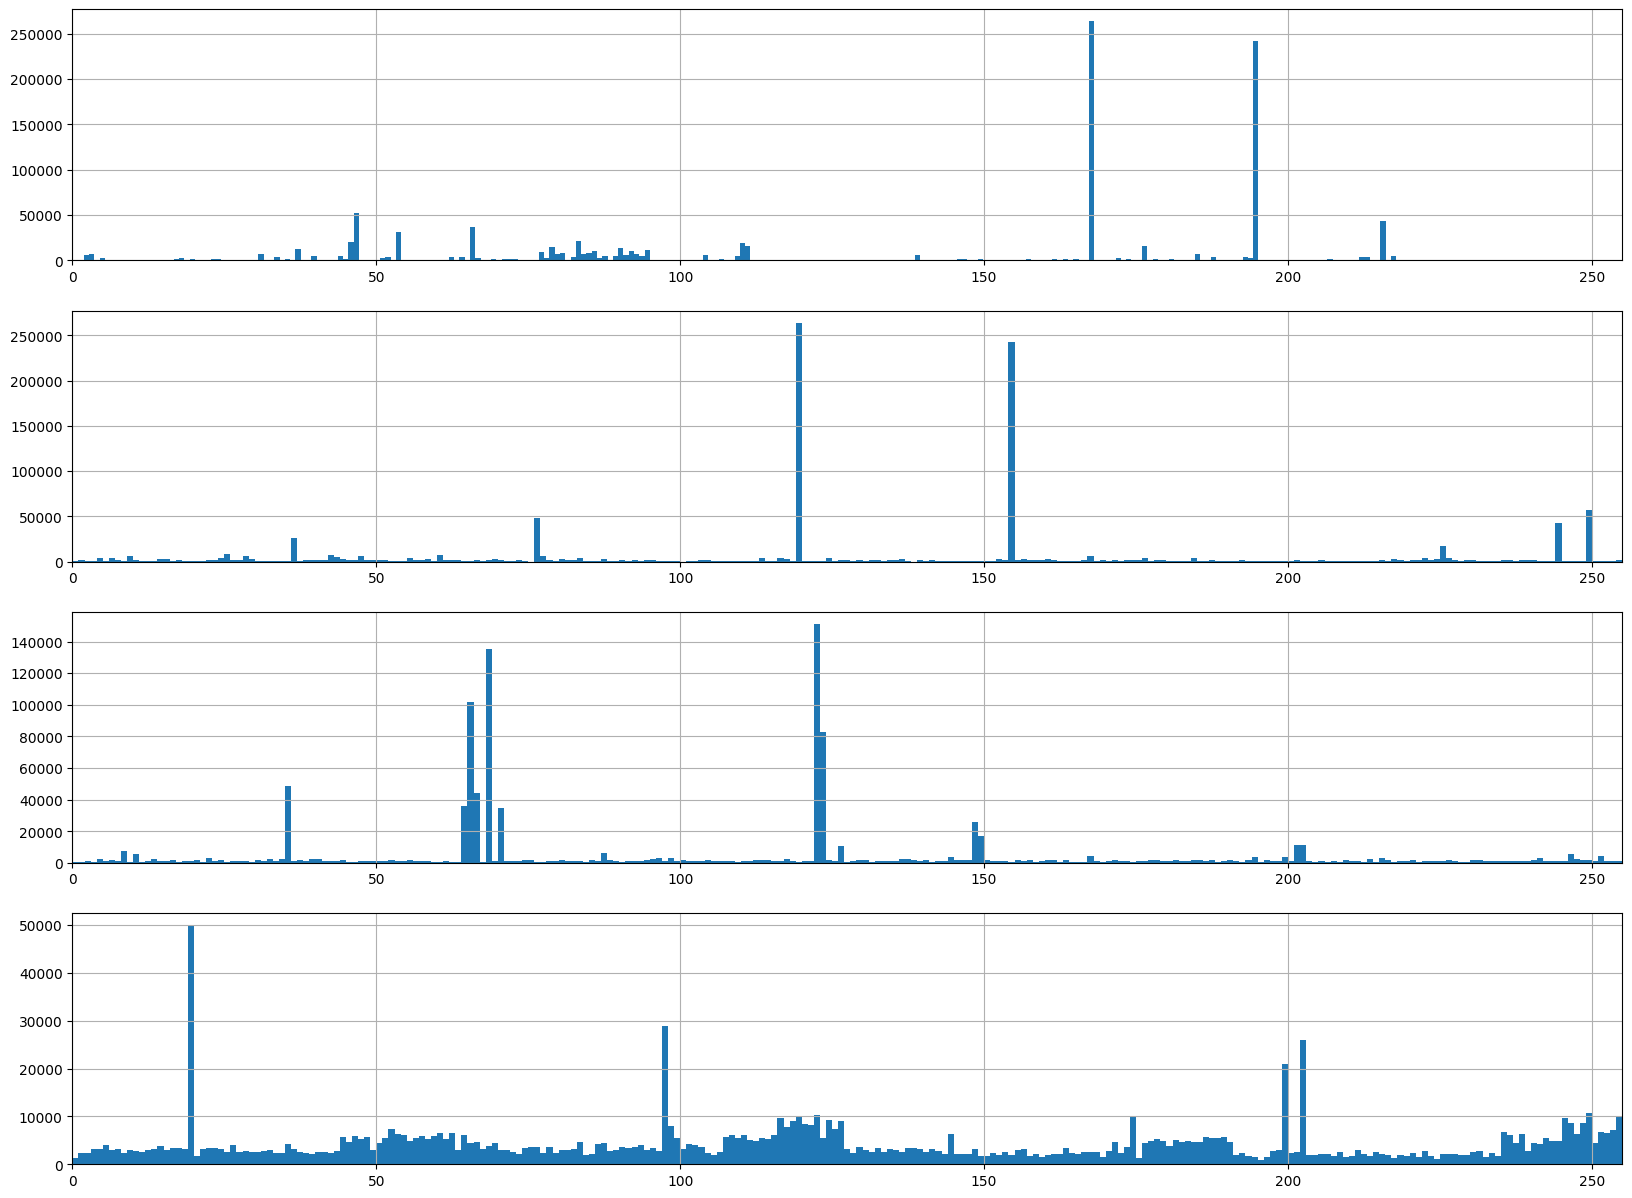

In [21]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))
for i in range(4):
	df_clean["IP"].apply(lambda x: int(x.split(".")[i])).hist(bins=255, ax=ax[i])
	ax[i].set_xlim([0, 255])
print(df_clean["IP"].apply(lambda x: int(x.split(".")[0])).max())
plt.show()

In [22]:
import json

normalize_path = os.path.join(ROOT_DIR, "models/normalize.json")

with open(normalize_path, "r") as f:
	normalize = json.load(f)
	df_temp = df_clean.copy()
	IP_octs = df_temp["IP"].apply(lambda x: x.split("."))
	for i in range(4):
		df_temp["IP_oct" + str(i)] = IP_octs.apply(lambda x: float(x[i]))
		mean, std = df_temp["IP_oct" + str(i)].mean(), df_temp["IP_oct" + str(i)].std()
		df_temp["IP_oct" + str(i)] = (df_temp["IP_oct" + str(i)] - mean) / std
		normalize["IP_oct" + str(i)] = {"mean": mean, "std": std}
	json.dump(normalize, open(normalize_path, "w"))

df_temp = df_temp.drop(columns=["IP"])
df_clean = df_temp.copy()
df_clean.head()

,date,petition,URL,status,bytes,referer,user-agent,level,group,elapsed,order,IP_oct0,IP_oct1,IP_oct2,IP_oct3
121428,2024-01-22 00:00:00+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,14921,0.000000,0,-1.478924,-0.936277,-1.236864,-1.435408
874855,2024-01-22 00:00:01+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5223,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,14921,0.693147,1,-1.478924,-0.936277,-1.236864,-1.435408
491693,2024-01-22 00:00:06+01:00,GET,/ca/noticias/84/sitges-obt%C3%A9-el-certificat...,404,2509,-,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",5,12379,0.000000,2,-1.594980,-0.920316,1.101653,-0.978923
949996,2024-01-22 00:00:06+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0,20285,0.000000,3,-1.478924,-0.936277,-1.236864,-1.435408
696091,2024-01-22 00:00:07+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5260,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0,20285,0.693147,4,-1.478924,-0.936277,-1.236864,-1.435408


### Date

In [23]:
df_clean["date"] = df["date"].str.split("+").str[0]
df_clean["date"].head()

121428    2024-01-22 16:35:21
874855    2024-01-27 21:26:36
491693    2024-01-25 08:58:14
949996    2024-01-28 11:43:51
696091    2024-01-26 17:23:18
Name: date, dtype: object

In [24]:
def sin_transform(x, period=24):
	return np.sin(2 * np.pi * x / period)

def cos_transform(x, period=24):
	return np.cos(2 * np.pi * x / period)

df_temp = df_clean.copy()

In [25]:
df_temp["date"] = pd.to_datetime(df_temp["date"])
df_temp["month"] = df_temp["date"].dt.month
df_temp["day"] = df_temp["date"].dt.day
df_temp["weekday"] = df_temp["date"].dt.weekday
df_temp["hour"] = df_temp["date"].dt.hour
df_temp["minute"] = df_temp["date"].dt.minute

In [26]:
df_temp["month_sin"] = sin_transform(df_temp["month"], 12)
df_temp["month_cos"] = cos_transform(df_temp["month"], 12)
df_temp["day_sin"] = sin_transform(df_temp["day"], 31)
df_temp["day_cos"] = cos_transform(df_temp["day"], 31)
df_temp["weekday_sin"] = sin_transform(df_temp["weekday"], 7)
df_temp["weekday_cos"] = cos_transform(df_temp["weekday"], 7)
df_temp["hour_sin"] = sin_transform(df_temp["hour"], 24)
df_temp["hour_cos"] = cos_transform(df_temp["hour"], 24)
df_temp["minute_sin"] = sin_transform(df_temp["minute"], 60)
df_temp["minute_cos"] = cos_transform(df_temp["minute"], 60)

df_temp.drop(["date", 'month', 'day', 'weekday', 'hour', 'minute'], axis=1, inplace=True)

In [27]:
df_clean = df_temp.copy()
df_clean.sample(frac=1, random_state=42).reset_index(drop=True).head()

,petition,URL,status,bytes,referer,user-agent,level,group,elapsed,order,...,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos
0,GET,/plantilles/turisme/css/font/Intro-Black-Caps....,200,14746,https://www.sitgesanytime.com/en/pl409/blog/id...,Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like...,0,32623,0.000000,294460,...,0.5,0.866025,-0.724793,0.688967,-0.974928,-0.222521,0.258819,0.965926,0.500000,0.866025
1,GET,/comu/js/jquery-ui-1.13.1/jquery-ui.min.js HTT...,200,67742,https://www.sitgesanytime.com/es/planifica-el-...,Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:...,0,3423,0.000000,716149,...,0.5,0.866025,-0.937752,0.347305,0.433884,-0.900969,-0.965926,0.258819,0.994522,-0.104528
2,GET,/ca/pl349/actualitat/noticies/id189/l-exposici...,200,13883,-,Mozilla/5.0 (compatible; ImagesiftBot; +images...,0,29393,2.197225,238657,...,0.5,0.866025,-0.968077,-0.250653,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
3,GET,/ca/noticias/20/la-gay-pride-reivindica-els-dr...,404,7269,-,Mozilla/5.0 (compatible; DotBot/1.2; +https://...,10,8435,1.098612,602556,...,0.5,0.866025,-0.968077,-0.250653,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
4,GET,/plantilles/turisme/css/estils-mw500.css?v=14 ...,200,1233,https://www.sitgesanytime.com/fr/pl50/planifie...,Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:...,0,3421,0.000000,347541,...,0.5,0.866025,-0.968077,-0.250653,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


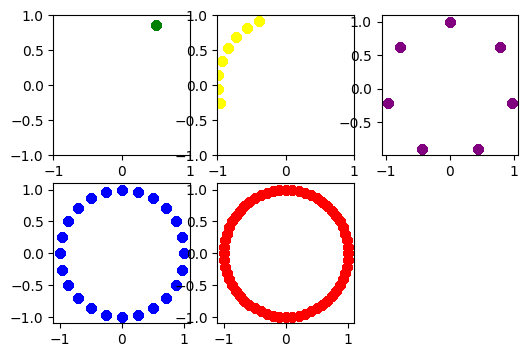

In [28]:
plt.figure(figsize=(3*2, 2*2))
sample_df = df_clean.sample(10000, random_state=42).reset_index(drop=True)
plt.subplot(2, 3, 1)
plt.scatter(sample_df["month_sin"], sample_df["month_cos"], color="green")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.subplot(2, 3, 2)
plt.scatter(sample_df["day_sin"], sample_df["day_cos"], color="yellow")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.subplot(2, 3, 3)
plt.scatter(sample_df["weekday_sin"], sample_df["weekday_cos"], color="purple")
plt.subplot(2, 3, 4)
plt.scatter(sample_df["hour_sin"], sample_df["hour_cos"], color="blue")
plt.subplot(2, 3, 5)
plt.scatter(sample_df["minute_sin"], sample_df["minute_cos"], color="red")

plt.show()

### Petition

In [29]:
df_clean["petition"].value_counts()

petition
GET        1024862
POST         27258
HEAD         24800
-              436
CONNECT         29
OPTIONS          7
USER             1
Name: count, dtype: int64

In [30]:
df_clean = pd.get_dummies(df_clean, columns=["petition"], dtype=int)
columns_to_combine = ["petition_CONNECT", "petition_OPTIONS", "petition_USER"]
df_clean["petition_other"] = df_clean[columns_to_combine].max(axis=1) # combine using OR
df_clean = df_clean.drop(columns=columns_to_combine)
print(df_clean["petition_other"].value_counts())
df_clean.head()

petition_other
0    1077356
1         37
Name: count, dtype: int64


,URL,status,bytes,referer,user-agent,level,group,elapsed,order,IP_oct0,...,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos,petition_-,petition_GET,petition_HEAD,petition_POST,petition_other
121428,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,14921,0.000000,0,-1.478924,...,1.000000,-0.866025,-0.500000,-0.500000,-0.866025,0,0,1,0,0
874855,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5223,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,14921,0.693147,1,-1.478924,...,-0.222521,-0.707107,0.707107,0.406737,-0.913545,0,0,1,0,0
491693,/ca/noticias/84/sitges-obt%C3%A9-el-certificat...,404,2509,-,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",5,12379,0.000000,2,-1.594980,...,-0.900969,0.866025,-0.500000,-0.207912,0.978148,0,1,0,0,0
949996,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0,20285,0.000000,3,-1.478924,...,0.623490,0.258819,-0.965926,-0.978148,-0.207912,0,0,1,0,0
696091,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5260,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0,20285,0.693147,4,-1.478924,...,-0.900969,-0.965926,-0.258819,0.669131,-0.743145,0,0,1,0,0


### URL

In [31]:
df_temp = df_clean.copy()
df_temp["URL"].str.contains(r"HTTP/\d+\.\d+").value_counts()

URL
True     1076959
False        432
Name: count, dtype: int64

In [32]:
df_temp = df_temp[df_temp["URL"].str.contains(r"HTTP/\d+\.\d+").fillna(False)]

In [33]:
from skipgram import *

embeddings_url = load_embeddings(os.path.join(ROOT_DIR, "models/embeddings-url.pt"))
idx2word_url = load_idx2word(os.path.join(ROOT_DIR, "models/idx2word-url.json"))
tokenizer_url = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-url")
embeddings_url.shape, embeddings_url.mean(), embeddings_url.std()

(torch.Size([923, 30]), tensor(0.0502), tensor(0.7491))

In [34]:
# --- example of how to get the embeddings of the urls ---
# --- running might take ~1:30 min and 3.3 GB ---
# urls_embeddings = []
# word2idx_url = {word: idx for idx, word in idx2word_url.items()}
# for url in tqdm(df_temp["URL"]):
# 	tokens = tokenizer_url.encode(url).tokens
# 	tokens_idx = get_idx(tokens, word2idx_url)
# 	url_embedding = embeddings_url[tokens_idx]
# 	urls_embeddings.append(url_embedding.to(torch.float32))

In [35]:
df_clean = df_temp.copy()

### Status

In [36]:
df_temp = df_clean.copy()
df_temp["status"] = df_temp["status"].apply(lambda x: str(x)[0])
df_temp["status_1"] = False
df_temp = pd.get_dummies(df_temp, columns=["status"], dtype=int)
df_clean = df_temp.copy()
df_clean.head()

,URL,bytes,referer,user-agent,level,group,elapsed,order,IP_oct0,IP_oct1,...,petition_-,petition_GET,petition_HEAD,petition_POST,petition_other,status_1,status_2,status_3,status_4,status_5
121428,/fr/pag492/explora-platges-i-ports-2/id12/les-...,4840,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,14921,0.000000,0,-1.478924,-0.936277,...,0,0,1,0,0,False,0,1,0,0
874855,/fr/pag492/explora-platges-i-ports-2/id12/les-...,5223,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,14921,0.693147,1,-1.478924,-0.936277,...,0,0,1,0,0,False,1,0,0,0
491693,/ca/noticias/84/sitges-obt%C3%A9-el-certificat...,2509,-,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",5,12379,0.000000,2,-1.594980,-0.920316,...,0,1,0,0,0,False,0,0,1,0
949996,/fr/pag492/explora-platges-i-ports-2/id12/les-...,4840,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0,20285,0.000000,3,-1.478924,-0.936277,...,0,0,1,0,0,False,0,1,0,0
696091,/fr/pag492/explora-platges-i-ports-2/id12/les-...,5260,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0,20285,0.693147,4,-1.478924,-0.936277,...,0,0,1,0,0,False,1,0,0,0


### Bytes

<Axes: >

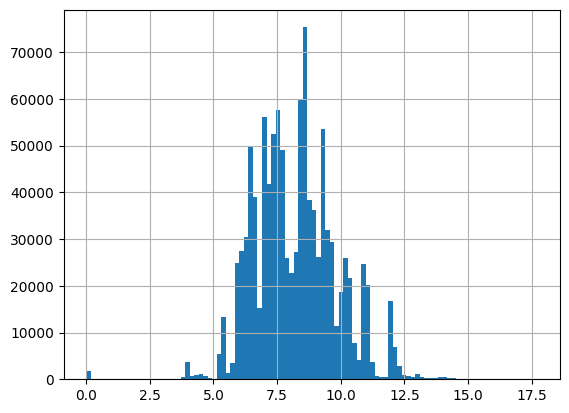

In [37]:
df_temp = df_clean.copy()
df_temp["bytes"] = np.log(df_temp["bytes"]+1)
df_temp["bytes"].hist(bins=100)

<Axes: >

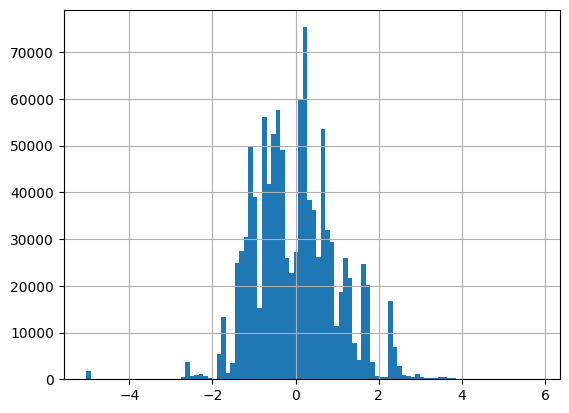

In [38]:
mean, std = df_temp["bytes"].mean(), df_temp["bytes"].std()
bytes_scaled = (df_temp["bytes"] - mean) / std
df_temp["bytes"] = bytes_scaled
df_clean = df_temp.copy()

with open(normalize_path, "r") as f:
	normalize = json.load(f)
	normalize["bytes"] = {"mean": mean, "std": std}
	json.dump(normalize, open(normalize_path, "w"))

df_clean["bytes"].hist(bins=100)

### Referer

In [39]:
embeddings_referer = load_embeddings(os.path.join(ROOT_DIR, "models/embeddings-referer.pt"))
idx2word_referer = load_idx2word(os.path.join(ROOT_DIR, "models/idx2word-referer.json"))
tokenizer_referer = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-referer")
embeddings_referer.shape, embeddings_referer.mean(), embeddings_referer.std()

(torch.Size([1058, 30]), tensor(0.1369), tensor(0.8011))

In [40]:
df_temp = df_clean.copy()
df_temp = df_temp.dropna(subset=["referer"])
df_temp["referer"].isnull().sum()

0

In [41]:
# --- example of how to get the embeddings of the referers ---
# --- running might take ~1:30 min and 3.3 GB ---
# referers_embeddings = []
# word2idx_referer = {word: idx for idx, word in idx2word_referer.items()}
# for referer in tqdm(df_temp["referer"]):
# 	tokens = tokenizer_referer.encode(referer).tokens
# 	tokens_idx = get_idx(tokens, word2idx_referer)
# 	referer_embedding = embeddings_referer[tokens_idx]
# 	referers_embeddings.append(referer_embedding.to(torch.float32))

In [42]:
df_clean = df_temp.copy()

### User agent

In [43]:
embeddings_useragent = load_embeddings(os.path.join(ROOT_DIR, "models/embeddings-useragent.pt"))
idx2word_useragent = load_idx2word(os.path.join(ROOT_DIR, "models/idx2word-useragent.json"))
tokenizer_useragent = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-useragent")
embeddings_useragent.shape, embeddings_useragent.mean(), embeddings_useragent.std()

(torch.Size([785, 30]), tensor(-0.0284), tensor(0.8834))

In [44]:
df_temp = df_clean.copy()
df_temp = df_temp.dropna(subset=["user-agent"])
df_temp["user-agent"].isnull().sum()

0

In [45]:
# --- example of how to get the embeddings of the user agent ---
# --- running might take ~1:30 min and 3.3 GB ---
# useragents_embeddings = []
# word2idx_useragent = {word: idx for idx, word in idx2word_useragent.items()}
# for useragent in tqdm(df_temp["user-agent"]):
# 	tokens = tokenizer_useragent.encode(useragent).tokens
# 	tokens_idx = get_idx(tokens, word2idx_useragent)
# 	useragent_embedding = embeddings_useragent[tokens_idx]
# 	useragents_embeddings.append(useragent_embedding.to(torch.float32))

In [46]:
df_clean = df_temp.copy()

In [47]:
print(df_clean.shape)
print(df_clean.isnull().sum().sum())
df_clean.head()

(1076925, 32)
0


,URL,bytes,referer,user-agent,level,group,elapsed,order,IP_oct0,IP_oct1,...,petition_-,petition_GET,petition_HEAD,petition_POST,petition_other,status_1,status_2,status_3,status_4,status_5
121428,/fr/pag492/explora-platges-i-ports-2/id12/les-...,0.157270,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,14921,0.000000,0,-1.478924,-0.936277,...,0,0,1,0,0,False,0,1,0,0
874855,/fr/pag492/explora-platges-i-ports-2/id12/les-...,0.203884,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,14921,0.693147,1,-1.478924,-0.936277,...,0,0,1,0,0,False,1,0,0,0
491693,/ca/noticias/84/sitges-obt%C3%A9-el-certificat...,-0.244845,-,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",5,12379,0.000000,2,-1.594980,-0.920316,...,0,1,0,0,0,False,0,0,1,0
949996,/fr/pag492/explora-platges-i-ports-2/id12/les-...,0.157270,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0,20285,0.000000,3,-1.478924,-0.936277,...,0,0,1,0,0,False,0,1,0,0
696091,/fr/pag492/explora-platges-i-ports-2/id12/les-...,0.208205,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0,20285,0.693147,4,-1.478924,-0.936277,...,0,0,1,0,0,False,1,0,0,0


In [48]:
df_clean.columns

Index(['URL', 'bytes', 'referer', 'user-agent', 'level', 'group', 'elapsed',
       'order', 'IP_oct0', 'IP_oct1', 'IP_oct2', 'IP_oct3', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos',
       'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'petition_-',
       'petition_GET', 'petition_HEAD', 'petition_POST', 'petition_other',
       'status_1', 'status_2', 'status_3', 'status_4', 'status_5'],
      dtype='object')

### Level

In [49]:
df_temp = df_clean.copy()
df_temp["level"] = df_temp["level"].apply(lambda x: 15 if x == -1 else x)
df_temp["level"] = df_temp["level"] / 15
df_temp["level"].mean(), df_temp["level"].std()
df_clean = df_temp.copy()

In [53]:
# save df_clean tp csv
df_clean = df_clean.sort_values("order")
df_clean = df_clean.drop(columns=["order"])
df_clean.to_csv(os.path.join(ROOT_DIR, "data/sitges_access_clean.csv"), index=False)